In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ppscore as pps
import warnings
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
import seaborn as sns

warnings.filterwarnings('ignore')

In [2]:
# General functions and variables

le = preprocessing.LabelEncoder()

def encode_drop(df1, df2, column_name):
    return encode_drop_per_df(df1, column_name), encode_drop_per_df(df2, column_name)

def encode_drop_per_df(df, column_name):
    df['enc_'+column_name] = le.fit_transform(df[column_name].values)
    return df.drop(column_name, axis=1)

def bar(df, column_name, aggfunc=np.median, figsize=(4,4), xrotation=0):
    pivot = df.pivot_table(index=column_name,
                  values='SalePrice', aggfunc=aggfunc)

    pivot.sort_values('SalePrice').plot(kind='bar', color='blue', figsize=figsize)
    plt.xlabel(column_name)
    plt.ylabel('Median Sale Price')
    plt.xticks(rotation=xrotation)
    plt.show()
    
def encode(df1, df2, col_name, manual_map):
    df1[col_name] = df1[col_name].map(manual_map)
    df2[col_name] = df2[col_name].map(manual_map)
    return df1, df2

def encode_corr(df1, df2, col_name):
    pivot = df1.pivot_table(index=col_name,
                      values='SalePrice', aggfunc=np.median)
    manual_map = {}
    for i, (idx, _) in enumerate(pivot.sort_values('SalePrice').iterrows()):
        manual_map[idx] = i

    return encode(df1, df2, col_name, manual_map)

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [4]:
print (f"Train data shape: {train.shape}")
print (f"Test data shape: {test.shape}")

Train data shape: (1460, 81)
Test data shape: (1459, 80)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [7]:
def dummy(df, col):
    df_dummies = pd.get_dummies(df[col], drop_first=True, prefix=col)
    return df.join(df_dummies)

# MSSubClass

In [8]:
np.sort(train.MSSubClass.unique())

array([ 20,  30,  40,  45,  50,  60,  70,  75,  80,  85,  90, 120, 160,
       180, 190])

In [9]:
train.MSSubClass.value_counts(sort=True, dropna=False)

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

In [10]:
# Note: "150 - 1-1/2 STORY PUD - ALL AGES" is missing

In [11]:
new = [20,60,120,160]
old = [30,70]
def older_newer(x):
    if x in new:
        return 2
    elif x in old:
        return 1
    else: return 0

train['MSSubClass_OLDNEW'] = train.MSSubClass.apply(older_newer)
test['MSSubClass_OLDNEW'] = test.MSSubClass.apply(older_newer)

In [12]:
story1 = [20,30,40]
story15 = [45,50,150]
story2 = [60,70,160]
story25 = [75]

def story(x):
    if x in story1:
        return 4
    elif x in story15:
        return 3
    elif x in story2:
        return 2
    elif x in story25:
        return 1
    else: return 0

train['MSSubClass_STORY'] = train.MSSubClass.apply(story)
test['MSSubClass_STORY'] = test.MSSubClass.apply(story)

In [13]:
all_styles = [20,90,190]
all_ages = [40,45,50,75,90,150,190]
def all_styles_ages(x):
    if x in all_styles:
        return 2
    elif x in all_ages:
        return 1
    else: return 0

train['MSSubClass_STYLES_AGES'] = train.MSSubClass.apply(all_styles_ages)
test['MSSubClass_STYLES_AGES'] = test.MSSubClass.apply(all_styles_ages)

In [14]:
pud = [120,150,160,180]
train['MSSubClass_PUD'] = train.MSSubClass.apply(lambda x: 1 if x in pud else 0)
test['MSSubClass_PUD'] = test.MSSubClass.apply(lambda x: 1 if x in pud else 0)

In [15]:
attic_finished = [50]
attic_unfinished = [45]
attic_wfinished = [40]

def attic(x):
    if x in attic_finished:
        return 3
    elif x in attic_unfinished:
        return 2
    elif x in attic_wfinished:
        return 1
    else: return 0

train['MSSubClass_ATTIC'] = train.MSSubClass.apply(attic)
test['MSSubClass_ATTIC'] = test.MSSubClass.apply(attic)

In [16]:
# TODO: Study these features
split_multilevel = [80]
split_foyer = [85]
duplex = [90]
multilevel = [180]
family_conversion = [190]

def other(x):
    if x in split_multilevel:
        return 5
    elif x in split_foyer:
        return 4
    elif x in duplex:
        return 3
    elif x in multilevel:
        return 2
    elif x in family_conversion:
        return 1
    else: return 0

train['MSSubClass_OTHER'] = train.MSSubClass.apply(other)
test['MSSubClass_OTHER'] = test.MSSubClass.apply(other)

In [17]:
train.drop("MSSubClass",inplace=True, axis=1)
test.drop("MSSubClass",inplace=True, axis=1)
version = 'MSSubClass-dropped'

# MSZoning

In [18]:
np.sort(train.MSZoning.unique())

array(['C (all)', 'FV', 'RH', 'RL', 'RM'], dtype=object)

In [19]:
train.MSZoning.value_counts(sort=True, dropna=False)

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [20]:
test.MSZoning.value_counts(sort=True, dropna=False)

RL         1114
RM          242
FV           74
C (all)      15
RH           10
NaN           4
Name: MSZoning, dtype: int64

In [21]:
quality_pivot = train.pivot_table(index='MSZoning',
                  values='SalePrice', aggfunc=np.median)

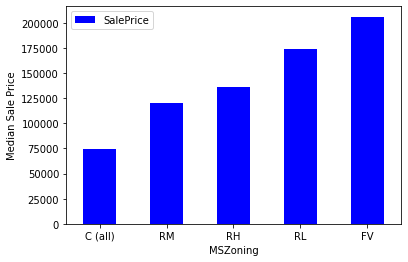

In [22]:
quality_pivot.sort_values('SalePrice').plot(kind='bar', color='blue')
plt.xlabel('MSZoning')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

In [23]:
featler = ['RH','RL','RP','RM',]
train['MSZoning_Residential'] = train.MSZoning.apply(lambda x: 1 if x in featler else 0)
test['MSZoning_Residential'] = test.MSZoning.apply(lambda x: 1 if x in featler else 0)

In [24]:
def density(x):
    if x in ['RH']:
        return 1
    elif  x in ['RM']:
        return 2
    elif x in ['RL']:
        return 3
    elif x in ['RP']:
        return 4
    else: return 0

train['MSZoning_Density'] = train.MSZoning.apply(density)
test['MSZoning_Density'] = test.MSZoning.apply(density)

In [25]:
featler = ['FV']
train['MSZoning_FloatingVillage'] = train.MSZoning.apply(lambda x: 1 if x in featler else 0)
test['MSZoning_FloatingVillage'] = test.MSZoning.apply(lambda x: 1 if x in featler else 0)

In [26]:
train.drop("MSZoning",inplace=True, axis=1)
test.drop("MSZoning",inplace=True, axis=1)

# Lot Frontage

In [27]:
np.sort(train.LotFrontage.unique())

array([ 21.,  24.,  30.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,
        40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,
        51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,
        62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,
        73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
        84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,
        95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105.,
       106., 107., 108., 109., 110., 111., 112., 114., 115., 116., 118.,
       120., 121., 122., 124., 128., 129., 130., 134., 137., 138., 140.,
       141., 144., 149., 150., 152., 153., 160., 168., 174., 182., 313.,
        nan])

In [28]:
train.LotFrontage.value_counts(sort=True, dropna=False)

NaN      259
60.0     143
70.0      70
80.0      69
50.0      57
        ... 
111.0      1
141.0      1
112.0      1
152.0      1
144.0      1
Name: LotFrontage, Length: 111, dtype: int64

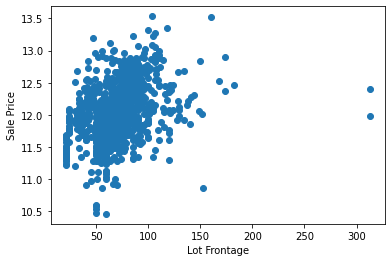

In [29]:
plt.scatter(x=train['LotFrontage'], y=np.log(train.SalePrice))
plt.ylabel('Sale Price')
plt.xlabel('Lot Frontage')
plt.show()

In [30]:
train.LotFrontage.fillna(0, inplace=True)
test.LotFrontage.fillna(0, inplace=True)

In [31]:
# TODO Remove outlier

# Lot Area

In [32]:
np.sort(train.LotArea.unique())

array([  1300,   1477,   1491, ..., 159000, 164660, 215245])

In [33]:
train.LotArea.value_counts(sort=True, dropna=False)

7200     25
9600     24
6000     17
8400     14
9000     14
         ..
13031     1
10991     1
8944      1
6897      1
8190      1
Name: LotArea, Length: 1073, dtype: int64

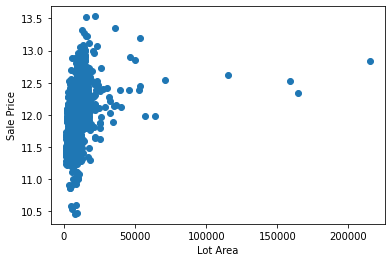

In [34]:
plt.scatter(x=train['LotArea'], y=np.log(train.SalePrice))
plt.ylabel('Sale Price')
plt.xlabel('Lot Area')
plt.show()

In [35]:
# TODO Remove outlier

# Street

In [36]:
np.sort(train.Street.unique())

array(['Grvl', 'Pave'], dtype=object)

In [37]:
train.Street.value_counts(sort=True, dropna=False)

Pave    1454
Grvl       6
Name: Street, dtype: int64

In [38]:
train['enc_street'] = le.fit_transform(train.Street.values)
test['enc_street'] = le.fit_transform(test.Street.values)

In [39]:
#train['enc_street'] = pd.get_dummies(train.Street, drop_first=True)
#test['enc_street'] = pd.get_dummies(train.Street, drop_first=True)

In [40]:
train.drop("Street",inplace=True, axis=1)
test.drop("Street",inplace=True, axis=1)

# Alley

In [41]:
train.Alley.value_counts(sort=True, dropna=False)

NaN     1369
Grvl      50
Pave      41
Name: Alley, dtype: int64

In [42]:
test.Alley.value_counts(sort=True, dropna=False)

NaN     1352
Grvl      70
Pave      37
Name: Alley, dtype: int64

In [43]:
train.Alley.fillna("No Alley", inplace=True)
test.Alley.fillna("No Alley", inplace=True)

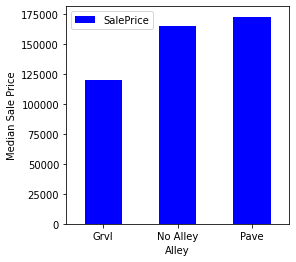

In [44]:
bar(train, "Alley")

In [45]:
# Manually encoding
Alley_map = {"Grvl":0, 
                 "No Alley":1, 
                 "Pave":2}
# Note: Manually encoding alley doesn't affect performance
#train['Alley'] = train['Alley'].map(Alley_map)
#test['Alley'] = test['Alley'].map(Alley_map)

In [46]:
train, test = encode_drop(train, test, "Alley")

# Lot Shape

In [47]:
train.LotShape.value_counts(sort=True, dropna=False)

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

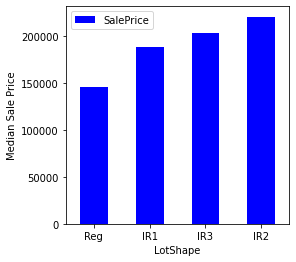

In [48]:
bar(train, "LotShape")

In [49]:
# Manually encoding - follow Median order
manual_map = {"IR3":1, 
                 "IR2":3,
                 "IR1":2, 
                 "Reg":0}

train['LotShape'] = train['LotShape'].map(manual_map)
test['LotShape'] = test['LotShape'].map(manual_map)

In [50]:
#train, test = encode_drop(train, test, "LotShape")

# Land Contour

In [51]:
train.LandContour.value_counts(sort=True, dropna=False)

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

In [52]:
test.LandContour.value_counts(sort=True, dropna=False)

Lvl    1311
HLS      70
Bnk      54
Low      24
Name: LandContour, dtype: int64

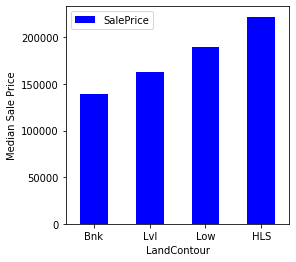

In [53]:
bar(train, "LandContour")

In [54]:
# Manually encoding - follow Median order
manual_map = {"Low":0, 
                 "HLS":1,
                 "Bnk":2, 
                 "Lvl":3}

# Note: Manually encoding alley doesn't affect performance
#train['LandContour'] = train['LandContour'].map(manual_map)
#test['LandContour'] = test['LandContour'].map(manual_map)

In [55]:
train, test = encode_drop(train, test, "LandContour")

# Utilities

In [56]:
train.Utilities.value_counts(sort=True, dropna=False)

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

In [57]:
test.Utilities.value_counts(sort=True, dropna=False)

AllPub    1457
NaN          2
Name: Utilities, dtype: int64

In [58]:
#train['enc_utilities'] = pd.get_dummies(train.Utilities, drop_first=True)
#test['enc_utilities'] = pd.get_dummies(train.Utilities, drop_first=True)

In [59]:
#train.drop("Utilities",inplace=True, axis=1)
#test.drop("Utilities",inplace=True, axis=1)

# Lot Config

In [60]:
train.LotConfig.value_counts(sort=True, dropna=False)

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

In [61]:
test.LotConfig.value_counts(sort=True, dropna=False)

Inside     1081
Corner      248
CulDSac      82
FR2          38
FR3          10
Name: LotConfig, dtype: int64

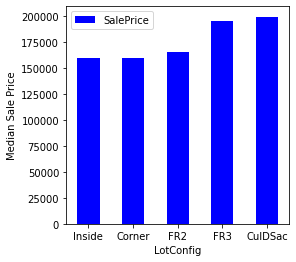

In [62]:
bar(train, "LotConfig")

In [63]:
# Manually encoding - follow Median order
manual_map = {"Inside":0, 
                 "Corner":1,
                 "FR2":2, 
                 "FR3":3, 
                 "CulDSac":4}

train['LotConfig'] = train['LotConfig'].map(manual_map)
test['LotConfig'] = test['LotConfig'].map(manual_map)

# Land Slope

In [64]:
train.LandSlope.value_counts(sort=True, dropna=False)

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

In [65]:
test.LandSlope.value_counts(sort=True, dropna=False)

Gtl    1396
Mod      60
Sev       3
Name: LandSlope, dtype: int64

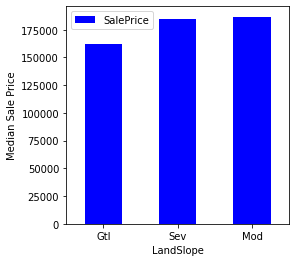

In [66]:
bar(train, "LandSlope")

In [67]:
# Manually encoding - follow Median order
manual_map = {"Gtl":0, 
                 "Sev":1,
                 "Mod":2}

train, test = encode(train, test, 'LandSlope', manual_map)

# Neighborhood

In [68]:
train.Neighborhood.value_counts(sort=True, dropna=False)

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

In [69]:
test.Neighborhood.value_counts(sort=True, dropna=False)

NAmes      218
OldTown    126
CollgCr    117
Somerst     96
Edwards     94
NridgHt     89
Gilbert     86
Sawyer      77
SawyerW     66
Mitchel     65
NWAmes      58
IDOTRR      56
Crawfor     52
BrkSide     50
Timber      34
NoRidge     30
StoneBr     26
SWISU       23
MeadowV     20
ClearCr     16
BrDale      14
NPkVill     14
Veenker     13
Blmngtn     11
Blueste      8
Name: Neighborhood, dtype: int64

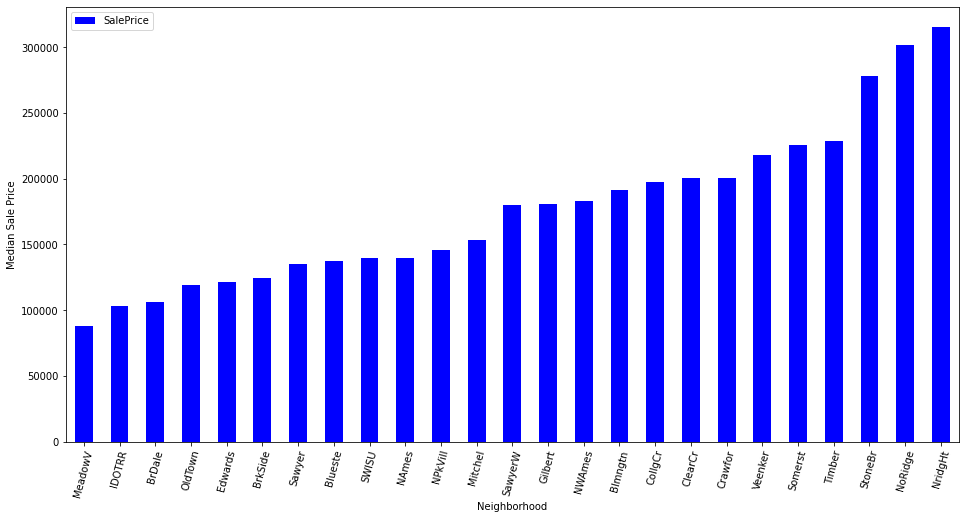

In [70]:
bar(train, "Neighborhood", figsize=(16,8), xrotation=75)

In [71]:
# Manually encoding - follow Median order
pivot = train.pivot_table(index="Neighborhood",
                  values='SalePrice', aggfunc=np.median)
manual_map = {}
for i, (idx, _) in enumerate(pivot.sort_values('SalePrice').iterrows()):
    manual_map[idx] = i

train, test = encode(train, test, 'Neighborhood', manual_map)

In [72]:
# Neighborhood -> Nominal
#train = pd.get_dummies(train, columns = ['Neighborhood'])
#test = pd.get_dummies(test, columns = ['Neighborhood'])

# Condition1: Proximity to various conditions

In [73]:
train.Condition1.value_counts(sort=True, dropna=False)

Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64

In [74]:
test.Condition1.value_counts(sort=True, dropna=False)

Norm      1251
Feedr       83
Artery      44
RRAn        24
PosN        20
RRAe        17
PosA        12
RRNe         4
RRNn         4
Name: Condition1, dtype: int64

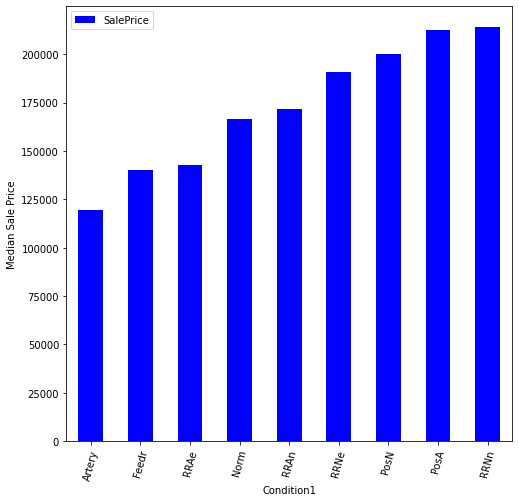

In [75]:
bar(train, "Condition1", figsize=(8,8), xrotation=75)

In [76]:
train = pd.get_dummies(train, columns = ['Condition1'])
test = pd.get_dummies(test, columns = ['Condition1'])

# Condition2: Proximity to various conditions (if more than one is present)

In [77]:
train.Condition2.value_counts(sort=True, dropna=False)

Norm      1445
Feedr        6
PosN         2
Artery       2
RRNn         2
PosA         1
RRAe         1
RRAn         1
Name: Condition2, dtype: int64

In [78]:
test.Condition2.value_counts(sort=True, dropna=False)

Norm      1444
Feedr        7
PosA         3
Artery       3
PosN         2
Name: Condition2, dtype: int64

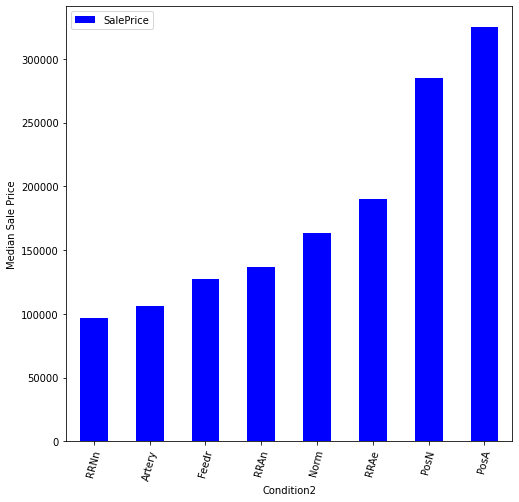

In [79]:
bar(train, "Condition2", figsize=(8,8), xrotation=75)

In [80]:
train = pd.get_dummies(train, columns = ['Condition2'])
test = pd.get_dummies(test, columns = ['Condition2'])

# BldgType: Type of dwelling

In [81]:
train.BldgType.value_counts(sort=True, dropna=False)

1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64

In [82]:
test.BldgType.value_counts(sort=True, dropna=False)

1Fam      1205
TwnhsE     113
Duplex      57
Twnhs       53
2fmCon      31
Name: BldgType, dtype: int64

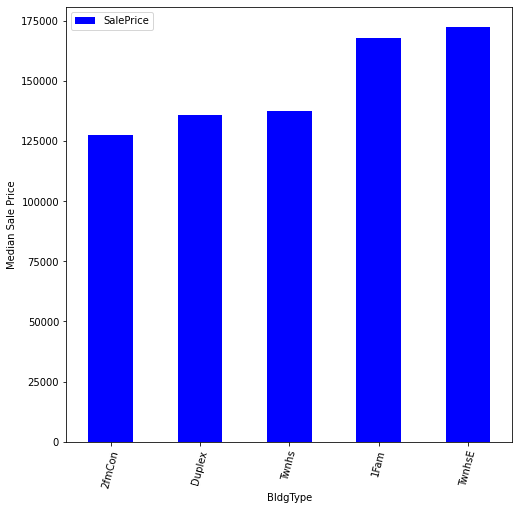

In [83]:
bar(train, "BldgType", figsize=(8,8), xrotation=75)

In [84]:
#train, test = encode_drop(train, test, "BldgType")

In [85]:
train = pd.get_dummies(train, columns = ['BldgType'])
test = pd.get_dummies(test, columns = ['BldgType'])

# HouseStyle: Style of dwelling

In [86]:
train.HouseStyle.value_counts(sort=True, dropna=False)

1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64

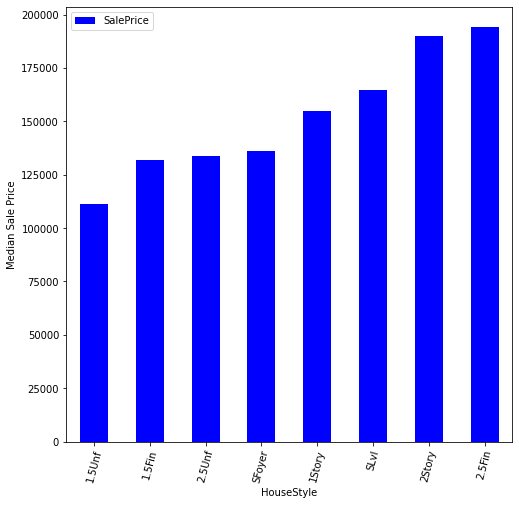

In [87]:
bar(train, "HouseStyle", figsize=(8,8), xrotation=75)

In [88]:
# Manually encoding - follow Median order
pivot = train.pivot_table(index="HouseStyle",
                  values='SalePrice', aggfunc=np.median)
manual_map = {}
for i, (idx, _) in enumerate(pivot.sort_values('SalePrice').iterrows()):
    manual_map[idx] = i

train, test = encode(train, test, 'HouseStyle', manual_map)

In [89]:
# TODO Split between finished and unfinished

In [90]:
story1 = ["1Story"]
story15 = ["1.5Fin", "1.5Unf"]
story2 = ["2.5Fin"]
story25 = ["2.5Unf"]

def story(x):
    if x in story25:
        return 4
    elif x in story2:
        return 3
    elif x in story15:
        return 2
    elif x in story1:
        return 1
    else: return 0

#train['HouseStyle_STORY'] = train.HouseStyle.apply(story)
#test['HouseStyle_STORY'] = test.HouseStyle.apply(story)

In [91]:
sFoyer = ["SFoyer"]
sLvl = ["SLvl"]

def foyer(x):
    if x in sLvl:
        return 2
    elif x in sFoyer:
        return 1
    else: return 0

#train['HouseStyle_FOYER'] = train.HouseStyle.apply(foyer)
#test['HouseStyle_FOYER'] = test.HouseStyle.apply(foyer)

In [92]:
#train['HouseStyle_FINISHED'] = train.HouseStyle.apply(lambda x: 1 if x in ["1.5Fin", "2.5Fin"] else 0)
#test['HouseStyle_UNFINISHED'] = test.HouseStyle.apply(lambda x: 1 if x in ["1.5Unf", "2.5Unf"] else 0)

In [93]:
#train.drop("HouseStyle",inplace=True, axis=1)
#test.drop("HouseStyle",inplace=True, axis=1)

# OverallQual: Rates the overall material and finish of the house

In [94]:
train.OverallQual.value_counts(sort=True, dropna=False)

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64

In [95]:
train['enc_OverallQual'] = le.fit_transform(train.OverallQual.values)
test['enc_OverallQual'] = le.fit_transform(test.OverallQual.values)

In [96]:
train.drop("OverallQual",inplace=True, axis=1)
test.drop("OverallQual",inplace=True, axis=1)

# OverallCond: Rates the overall condition of the house

In [97]:
train.OverallCond.value_counts(sort=True, dropna=False)

5    821
6    252
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: OverallCond, dtype: int64

In [98]:
train, test = encode_drop(train, test, "OverallCond")

# Year Built: Original construction date

In [99]:
train.YearBuilt.value_counts(sort=True, dropna=False)

2006    67
2005    64
2004    54
2007    49
2003    45
        ..
1904     1
1898     1
1893     1
1882     1
2010     1
Name: YearBuilt, Length: 112, dtype: int64

In [100]:
# Normalization has no impact om perf
#train.YearBuilt = (train.YearBuilt-train.YearBuilt.mean())/train.YearBuilt.std()

# YearRemodAdd: Remodel date
####  (same as construction date if no remodeling or additions)

In [101]:
train.YearRemodAdd.value_counts(sort=True, dropna=False)

1950    178
2006     97
2007     76
2005     73
2004     62
       ... 
2010      6
1983      5
1986      5
1952      5
1951      4
Name: YearRemodAdd, Length: 61, dtype: int64

In [102]:
# Normalization has no impact on perf
#train.YearRemodAdd = (train.YearRemodAdd-train.YearRemodAdd.mean())/train.YearRemodAdd.std()

# RoofStyle: Type of roof

In [103]:
train.RoofStyle.value_counts(sort=True, dropna=False)

Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64

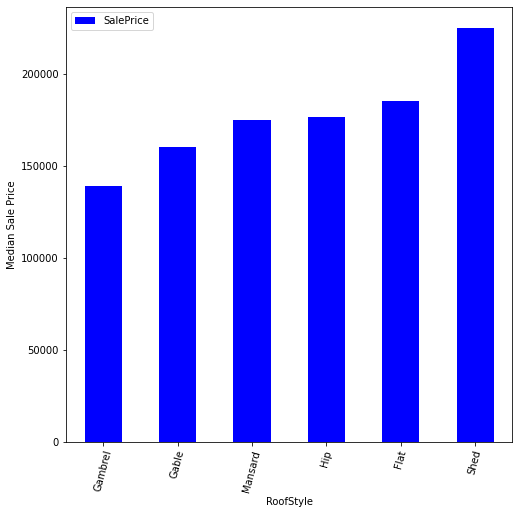

In [104]:
bar(train, "RoofStyle", figsize=(8,8), xrotation=75)

In [105]:
train, test = encode_drop(train, test, "RoofStyle")

# RoofMatl: Roof material

In [106]:
train.RoofMatl.value_counts(sort=True, dropna=False)

CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Metal         1
Membran       1
Roll          1
ClyTile       1
Name: RoofMatl, dtype: int64

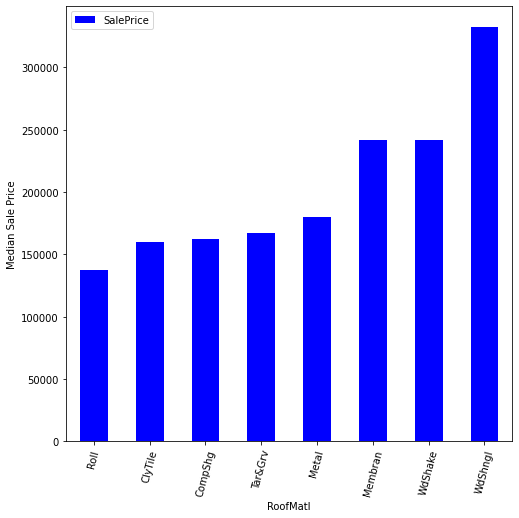

In [107]:
bar(train, "RoofMatl", figsize=(8,8), xrotation=75)

In [108]:
train = pd.get_dummies(train, columns = ['RoofMatl'])
test = pd.get_dummies(test, columns = ['RoofMatl'])

# Exterior1st: Exterior covering on house

In [109]:
train.Exterior1st.value_counts(sort=True, dropna=False)

VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
ImStucc      1
AsphShn      1
CBlock       1
Name: Exterior1st, dtype: int64

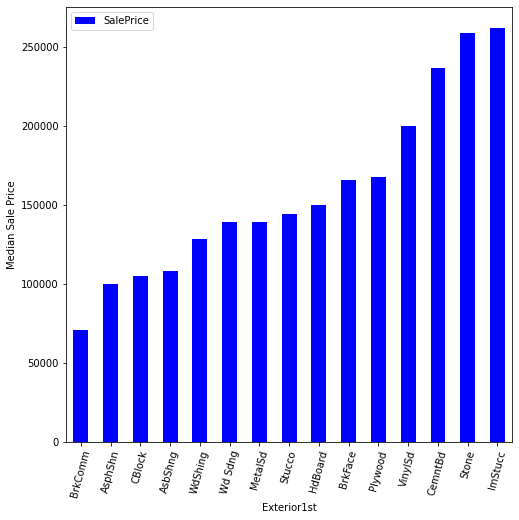

In [110]:
bar(train, "Exterior1st", figsize=(8,8), xrotation=75)

In [111]:
# TODO: Study the different materials
# Warning: encoding negatively impact the performance

# Exterior2nd: Exterior covering on house (if more than one material)

In [112]:
train.Exterior2nd.value_counts(sort=True, dropna=False)

VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
Other        1
CBlock       1
Name: Exterior2nd, dtype: int64

In [113]:
# Warning: negatively impact the performance
#train, test = encode_drop(train, test, "Exterior2nd")

# MasVnrType: Masonry veneer type

In [114]:
train.MasVnrType.value_counts(sort=True, dropna=False)

None       864
BrkFace    445
Stone      128
BrkCmn      15
NaN          8
Name: MasVnrType, dtype: int64

In [115]:
train.MasVnrType.fillna("Other", inplace=True)
test.MasVnrType.fillna("Other", inplace=True)

In [116]:
# Testing different encodings
train = pd.get_dummies(train, columns = ['MasVnrType'])
test = pd.get_dummies(test, columns = ['MasVnrType'])
#train, test = encode_corr(train, test, "MasVnrType")
#train, test = encode_drop(train, test, "MasVnrType")

# MasVnrArea: Masonry veneer area in square feet

In [117]:
train.MasVnrArea.value_counts(sort=True, dropna=False)

0.0      861
72.0       8
180.0      8
108.0      8
NaN        8
        ... 
388.0      1
426.0      1
653.0      1
796.0      1
415.0      1
Name: MasVnrArea, Length: 328, dtype: int64

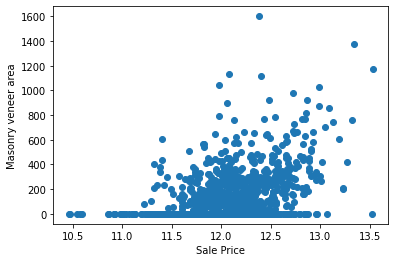

In [118]:
plt.scatter(x=np.log(train.SalePrice), y=train.MasVnrArea)
plt.xlabel('Sale Price')
plt.ylabel('Masonry veneer area')
plt.show()

In [119]:
train.MasVnrArea.fillna(0, inplace=True)
test.MasVnrArea.fillna(0, inplace=True)

# ExterQual: Evaluates the quality of the material on the exterior 

In [120]:
train.ExterQual.value_counts(sort=True, dropna=False)

TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64

In [ ]:
bar(train, "ExterQual", figsize=(8,8), xrotation=75)

In [ ]:
# Warning: negatively impact the performance
# Testing different encodings
train, test = encode(train, test, "ExterQual", {"TA": 2, "Gd": 3, "Ex": 4, "Fa":1, "Po":0})
#train = pd.get_dummies(train, columns = ['ExterQual'])
#test = pd.get_dummies(test, columns = ['ExterQual'])
#train, test = encode_corr(train, test, "ExterQual")
#train, test = encode_drop(train, test, "ExterQual")

# ExterCond: Evaluates the present condition of the material on the exterior

In [ ]:
train.ExterCond.value_counts(sort=True, dropna=False)

In [ ]:
# Warning: negatively impact the performance
# Testing different encodings
#train, test = encode(train, test, "ExterCond", {"TA": 2, "Gd": 3, "Ex": 4, "Fa":1, "Po":0})
train = pd.get_dummies(train, columns = ['ExterCond'])
#test = pd.get_dummies(test, columns = ['ExterCond'])
#train, test = encode_corr(train, test, "ExterCond")
#train, test = encode_drop(train, test, "ExterCond")

# Foundation: Type of foundation

In [ ]:
train.Foundation.value_counts(sort=True, dropna=False)

In [ ]:
# Warning: negatively impact the performance
# Testing different encodings
#train, test = encode(train, test, "Foundation", {"TA": 2, "Gd": 3, "Ex": 4, "Fa":1, "Po":0})
#train = pd.get_dummies(train, columns = ['Foundation'])
#test = pd.get_dummies(test, columns = ['Foundation'])
train, test = encode_corr(train, test, "Foundation")
#train, test = encode_drop(train, test, "Foundation")

# BsmtQual: Evaluates the height of the basement

In [ ]:
train.BsmtQual.value_counts(sort=True, dropna=False)

In [ ]:
#train.BsmtQual.fillna("NoBsmt", inplace=True)
#test.BsmtQual.fillna("NoBsmt", inplace=True)

In [ ]:
train.BsmtQual

In [ ]:
#train, test = encode_drop(train, test, "BsmtQual")

### Handling Null Value

In [ ]:
nulls = pd.DataFrame(train.isnull().sum().sort_values(ascending=False)[:25])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls

### Replace missing data

In [ ]:
data = train.select_dtypes(include=[np.number]).interpolate().dropna()

In [ ]:
# Test General normalization
#data = (data-data.mean())/data.std()
#data = (data-data.min())/(data.max()-data.min()) # Gives worst results

### Split data

In [ ]:
y = np.log(train.SalePrice)
X = data.drop(['SalePrice', 'Id'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                          X, y, random_state=42, test_size=.33)

# Modeling

In [ ]:
df_result = pd.DataFrame(columns=['Method','RMSE','GridParams'])

In [ ]:
def rmse(df, model):
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return df.append({'Method':model.__class__.__name__, 'RMSE':rmse}, ignore_index=True)

def grid_rmse(df, grid):
    rmse = np.sqrt(np.sqrt(np.abs(grid.best_score_)))
    if hasattr(grid, 'best_params_'):
        params = grid.best_params_
    return df.append({'Method':"{} Grid".format(grid.estimator.__class__.__name__), 'RMSE':rmse, 'GridParams':params}, ignore_index=True)

## Linear Regression

In [ ]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
#print ("Root Square is: \n", lr.score(X_test, y_test))
#print ('RMSE is: \n', mean_squared_error(y_test, predictions, squared=False))

# Add to the main array
df_result = rmse(df_result, lr)
df_result

## Ridge Regression

### Grid Search

In [ ]:
alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
ridge_model = linear_model.Ridge()
grid = GridSearchCV(estimator=ridge_model, param_grid=dict(alpha=alphas))
grid.fit(X_train, y_train)

In [ ]:
grid.best_estimator_

In [ ]:
grid.best_params_

In [ ]:
print(grid.best_estimator_)
df_result = grid_rmse(df_result, grid)

### Simple

In [ ]:
ridge_model = linear_model.Ridge(alpha=grid.best_estimator_.alpha)
ridge_model.fit(X_train, y_train)
preds_ridge = ridge_model.predict(X_test)
print(ridge_model.score(X_test, y_test))
print("Ridge Regression RMSE: {}".format(mean_squared_error(y_test, preds_ridge, squared=False)))
df_result = rmse(df_result, ridge_model)
df_result

## Lasso

In [ ]:
alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
lasso_model = linear_model.Lasso()
grid_lasso = GridSearchCV(estimator=lasso_model, param_grid=dict(alpha=alphas))
grid_lasso.fit(X_train, y_train)
df_result = grid_rmse(df_result, grid_lasso)
df_result

## Random Forest

### Grid Search

In [ ]:
# Search Ranfom Forest Grid
do_rf_grid = False

In [ ]:
if do_rf_grid:
    rf_params = {'n_estimators': range(150, 600, 10), 'max_depth': range(3, 15, 1),'min_samples_leaf':[0.04,0.06,0.08,0.1,0.12,0.14], 'max_features':[0.2,0.4,0.6,0.8]}

    grid_rf = GridSearchCV(estimator = RandomForestRegressor(),
                         param_grid = rf_params,
                         cv=10,
                         scoring='neg_mean_squared_error',
                         verbose=1,
                         n_jobs=-1)
    grid_rf.fit(X_train, y_train)
    df_result = grid_rmse(df_result, grid_rf)
    print('Best parameters found for rf: ', grid_rf.best_params_)
    print('Lowerst RMSE found for rf: ', np.sqrt(np.sqrt(np.abs(grid_rf.best_score_))))

### Simple

In [ ]:
rf = RandomForestRegressor(n_estimators = 400, min_samples_leaf=0.12, random_state=123)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print("Random Forest RMSE: {} ".format(mean_squared_error(y_test, rf_pred,squared=False)))
df_result = rmse(df_result, rf)
df_result

## Bayesian Regression

In [ ]:
bayesridge_model = linear_model.BayesianRidge()
bayesridge_model.fit(X_train, y_train)
df_result = rmse(df_result, bayesridge_model)
df_result

## Logistic Regression

In [ ]:
#clf = LogisticRegression(random_state=0).fit(X_train, y_train)
#df_result = rmse(df_result, clf)
#df_result

## CatBoost Regressor

In [ ]:
cbr = CatBoostRegressor().fit(X_train,y_train)
df_result = rmse(df_result, cbr)
df_result

## XGBoost

### Grid Search

In [ ]:
gbm_param_grid = {'learning_rate': [0.01, 0.1, 0.5, 0.9], 'n_estimators': [200], 'subsample':[0.3,0.5,0.9]}
grid_xgb = GridSearchCV(estimator=xgb.XGBRegressor(objective ='reg:squarederror'), param_grid=gbm_param_grid, scoring='neg_mean_squared_error', cv=4, verbose=1)
grid_xgb.fit(X_train,y_train)
df_result = grid_rmse(df_result, grid_xgb)
df_result

In [ ]:
xgbm = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1, learning_rate = 0.01,
                max_depth=5, alpha = 10, n_estimators = 1000)
xgbm.fit(X_train,y_train)
df_result = rmse(df_result, xgbm)
df_result

In [ ]:
# Intermediate results
print(df_result['RMSE'].to_string(index=False))

## Gradient Boost Regressor

In [ ]:
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = {'n_estimators': [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900]}

kfold = KFold(n_splits=num_folds)
grid_gb = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid_gb.fit(X=rescaledX, y=y_train)

df_result = grid_rmse(df_result, grid_gb)
df_result

## Extra Trees Regressor

In [ ]:
etr_model = ExtraTreesRegressor(n_estimators=80)
etr_model.fit(X=X_train, y=y_train)
df_result = rmse(df_result, etr_model)
df_result

# Results

In [ ]:
df_result.sort_values(by='RMSE')

In [ ]:
print(df_result['RMSE'].to_string(index=False))